# Description synthétique du projet et de ses objectifs

L’objectif est de se familiariser avec les données multimodales, comprendre la structure du dataset et
identifier les défis liés à la classification multi-label avant de procéder à l’entraînement du modèle.

# Chargement des données

In [1]:
!pip install kaggle

In [2]:
# Importer les bibliothèques nécessaires
import os

# Charger le fichier kaggle.json (monte Google Drive ou upload le fichier)
from google.colab import files
files.upload()  # Exécute cette cellule et choisis le fichier kaggle.json

# Créer le dossier .kaggle et déplacer le fichier
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Donner les permissions nécessaires
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c multi-label-classification-competition-2023

In [4]:
import zipfile
import os

zip_path = "/content/multi-label-classification-competition-2023.zip"
extract_path = "/content/data"

# Extraire le contenu du ZIP
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Vérifier le contenu après extraction
print(os.listdir(extract_path))


['COMP5329S1A2Dataset']


In [5]:
import pandas as pd

# Chemins des fichiers
metadata_train_path = "/content/data/COMP5329S1A2Dataset/train.csv"
#metadata_test_path = "/content/data/COMP5329S1A2Dataset/test.csv"
image_path = "/content/data/COMP5329S1A2Dataset/data"

# Charger les fichiers CSV avec gestion des erreurs
metadata_train = pd.read_csv(metadata_train_path, on_bad_lines='skip', quoting=3)
#metadata_test = pd.read_csv(metadata_test_path, on_bad_lines='skip', quoting=3)

# Concaténer les deux DataFrames
#metadata_df = pd.concat([metadata_train, metadata_test], ignore_index=True)

# Afficher les premières lignes pour vérifier
#metadata_df.head()
metadata_train.head()


,ImageID,Labels,Caption
0,0.jpg,1,"""Woman in swim suit holding parasol on sunny d..."
1,1.jpg,1 19,"""A couple of men riding horses on top of a gre..."
2,2.jpg,1,"""They are brave for riding in the jungle on th..."
3,3.jpg,8 3 13,"""a black and silver clock tower at an intersec..."
4,4.jpg,8 3 7,"""A train coming to a stop on the tracks out si..."


# Exploration des données

In [6]:
# Taille du dataset
metadata_train.shape

(29237, 3)

In [7]:
# Vérification des valeurs vides
metadata_train.isnull().sum()

,0
ImageID,0
Labels,4
Caption,4


In [8]:
# Analyse de la variable cible, identification des valeurs uniques
distribution_cible = metadata_train['Labels'].value_counts()
print(distribution_cible)

Labels
1               13724
17                949
1 15              852
1 3               718
16                656
                ...  
8 1 11 3            1
3 5 6               1
1 3 4 6 8 13        1
3 13 14             1
1 10 13 7           1
Name: count, Length: 760, dtype: int64


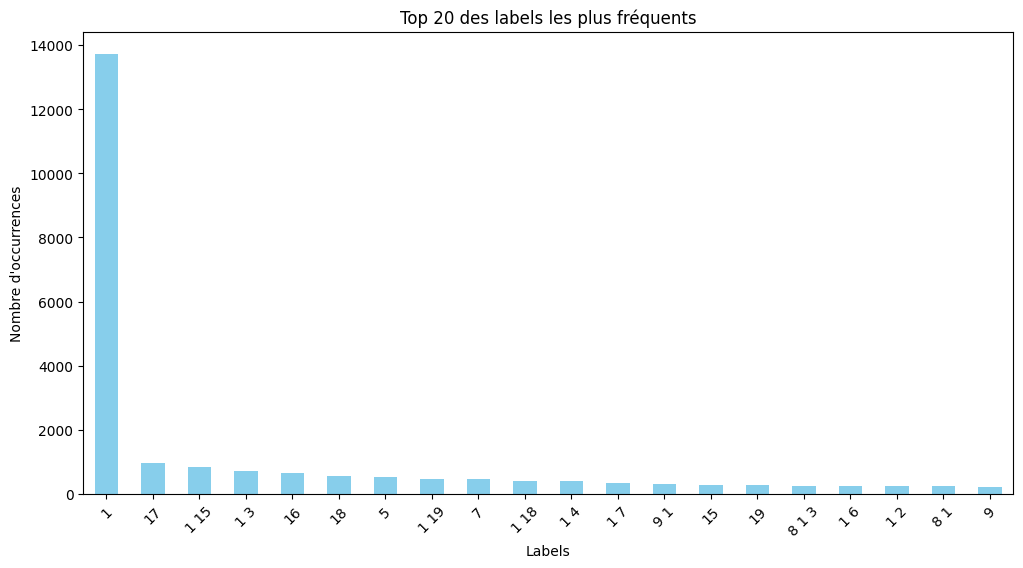

In [9]:
import matplotlib.pyplot as plt

# Afficher cette distribution dans un histogramme
plt.figure(figsize=(12, 6))
distribution_cible[:20].plot(kind='bar', color='skyblue') # Affichage des 20 labels les plus fréquents
plt.xlabel("Labels")
plt.ylabel("Nombre d'occurrences")
plt.title("Top 20 des labels les plus fréquents")
plt.xticks(rotation=45)  # Rotation des labels pour meilleure lisibilité
plt.show()

On peut donc voir dans cette histogramme un énorme désquilibre au niveau des classes. L'analyse de la variable cible révèle un fort déséquilibre, avec une seule classe représentant près de la moitié des enregistrements. Pour corriger ce déséquilibre, nous pouvons appliquer différentes stratégies : le sous-échantillonnage pour réduire la taille de la classe majoritaire, le sur-échantillonnage pour augmenter artificiellement les classes minoritaires, ou SMOTE pour générer de nouvelles instances synthétiques et équilibrer les données

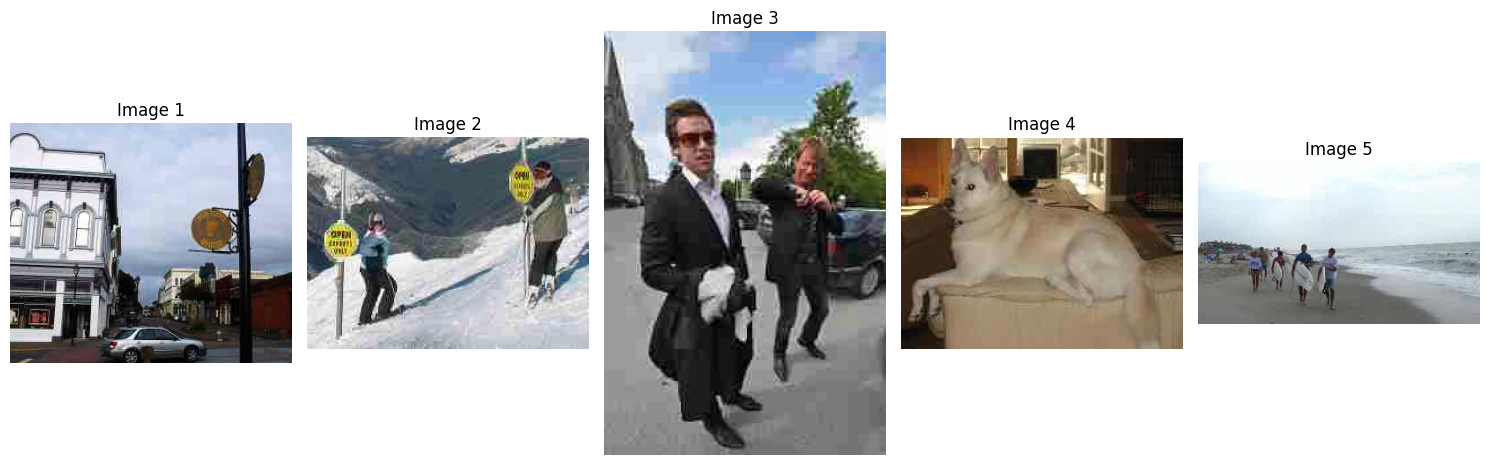

In [10]:
import random
from PIL import Image

# Chargement des images depuis le chemin
image_path = "/content/data/COMP5329S1A2Dataset/data"

# Liste de tous les fichiers dans le répertoire
all_images = os.listdir(image_path)

# Sélection de 5 images aléatoires
random_images = random.sample(all_images, 5)

# Création de la figure avec un grid 1x5 pour afficher 5 images
plt.figure(figsize=(15, 5))

# Affichage des 5 images
for i, image_name in enumerate(random_images):
    image_full_path = os.path.join(image_path, image_name)

    # Chargement de l'image
    image = Image.open(image_full_path)

    # Affichage de l'image dans la sous-figure (subplot)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(f"Image {i+1}")
    plt.axis('off')  # Masque les axes

plt.tight_layout()
plt.show()


Quelques exemples de descriptions :
         ImageID                                            Caption
19359  19867.jpg  "A bird flies through the air with its wings s...
18103  18576.jpg          "A man water skiing while using one ski."
17220  17667.jpg   "A little girl sitting at a table with a donut."
12034  12345.jpg         "A man is making waves while surf skiing."
19801  20318.jpg  "A baseball player standing in a position to p...

Longueur moyenne des descriptions : 10.43 mots


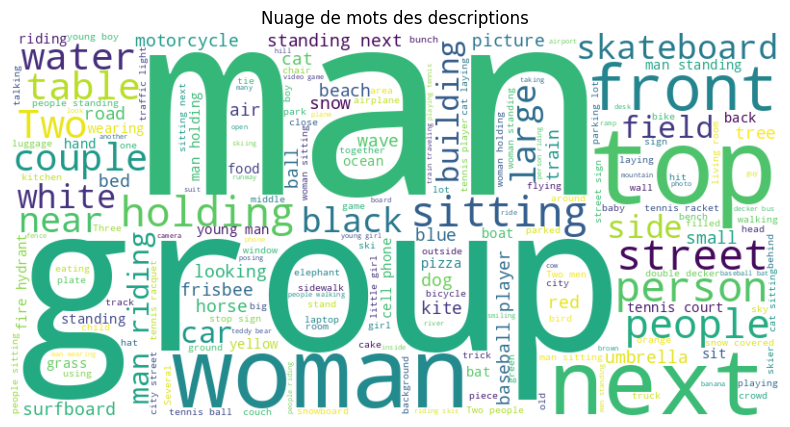

In [11]:
from wordcloud import WordCloud

# Chargement des métadonnées (supposons que le fichier CSV contient 'ImageID' et 'Caption')
metadata = pd.read_csv(metadata_train_path, on_bad_lines='skip', quoting=3)

# Affichage de quelques exemples de descriptions
print("Quelques exemples de descriptions :")
print(metadata[['ImageID', 'Caption']].sample(5))

# Calcul de la longueur moyenne des descriptions (en nombre de mots)
metadata['description_length'] = metadata['Caption'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
average_description_length = metadata['description_length'].mean()
print(f"\nLongueur moyenne des descriptions : {average_description_length:.2f} mots")

# Création du nuage de mots (Word Cloud)
# Fusionner toutes les descriptions dans un seul texte
# Utiliser dropna() pour s'assurer qu'on ne fusionne pas de valeurs NaN
all_descriptions = " ".join(metadata['Caption'].dropna())

# Création du nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_descriptions)

# Affichage du nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots des descriptions")
plt.show()
